In [1]:
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
import seaborn as sns
sns.set_theme(color_codes=True)
from scipy import stats
import statsmodels.api as sm
import numpy as np
import json

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Read the Data

In [2]:
first_session_raw_data = pd.read_csv('Data/gono-go-game-first-round.csv', index_col=0).reset_index()
# first_session_raw_data = first_session_raw_data[first_session_raw_data['recorded_at'] > '2022-01-18']

num_all_experimenters = len(first_session_raw_data.mturkID.unique())
num_excluded_experimenters = 0

first_session_raw_data['correct'] = first_session_raw_data.correct == 'true'
first_session_raw_data.head()

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (32,65) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,run_id,condition,rt,url,trial_type,trial_index,time_elapsed,internal_node_id,experiment_id,assignmentID,mturkID,hitID,exp_final_status,success,timeout,failed_images,failed_audio,failed_video,stimulus,response,exp_stage,view_history,exp_part,question_order,quiz_score,recorded_at,ip,user_agent,device,browser,browser_version,platform,platform_version,source_code_version,focus_screen,color,cond,cond_action,cond_outcome,block,side,x_circle,y_circle,choice,correct,curr_bonus,trial_bonus,outcome,feedback_points,prob_fall,expected_feedback,agg_fb_pts,error_block,num_gos,num_nogos,suspicious,hitId,workerId,assignmentId,a,tp_a,b,tp_b,c,tp_c,suspicious_type
0,10,1,1429.1999999955297,https://raw.githubusercontent.com/Sepsad/Ortho...,external-html,0,1440,0.0-0.0,GNG_ev45gnlk,"""","""","""",not_completed_by_failing_quiz,"""","""","""","""","""","""","""","""","""","""","""","""",2021-11-12 15:05:54,95.217.7.68,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Macintosh,Chrome,95.0.4638.69,OS X,10_15_7,ff253546778cd407e57361676f185c6a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,1,1251.1999999955297,https://raw.githubusercontent.com/Sepsad/Ortho...,external-html,1,2703,0.0-1.0,GNG_ev45gnlk,"""","""","""",not_completed_by_failing_quiz,"""","""","""","""","""","""","""","""","""","""","""","""",2021-11-12 15:05:54,95.217.7.68,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Macintosh,Chrome,95.0.4638.69,OS X,10_15_7,ff253546778cd407e57361676f185c6a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,1,"""","""",preload,2,3543,0.0-2.0,GNG_ev45gnlk,"""","""","""",not_completed_by_failing_quiz,true,false,[],[],[],"""","""","""","""","""","""","""",2021-11-12 15:05:54,95.217.7.68,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Macintosh,Chrome,95.0.4638.69,OS X,10_15_7,ff253546778cd407e57361676f185c6a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,1,977.1000000014901,"""",html-button-response,3,4522,0.0-3.0,GNG_ev45gnlk,"""","""","""",not_completed_by_failing_quiz,"""","""","""","""","""",<img src='../img/welcome.gif' style='height: 2...,0,first_welcome,"""","""","""","""",2021-11-12 15:05:54,95.217.7.68,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Macintosh,Chrome,95.0.4638.69,OS X,10_15_7,ff253546778cd407e57361676f185c6a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,1,3232.89999999851,"""",instructions,4,7756,0.0-4.0,GNG_ev45gnlk,"""","""","""",not_completed_by_failing_quiz,"""","""","""","""","""","""","""",before_instructions,"[{""page_index"":0,""viewing_time"":713},{""page_in...",before_instructions,"""","""",2021-11-12 15:05:54,95.217.7.68,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Macintosh,Chrome,95.0.4638.69,OS X,10_15_7,ff253546778cd407e57361676f185c6a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Apply exclusion criteria

1. Fail the quiz of instructions more than twice.
2. Change the tab or window of the experiment.

In [3]:
first_session_clean_data = first_session_raw_data[(first_session_raw_data.exp_final_status == 'fully_completed')]

num_excluded_experimenters = len(first_session_raw_data.mturkID.unique()) - len(first_session_clean_data.mturkID.unique())

print("Number of participants excluded by this criterias:", num_excluded_experimenters)

Number of participants excluded by this criterias: 31


3. Respond randomly, always go or never go.

    * Note: We exclude who repond randomly, always go or nogo in each 3 block

In [4]:
susp = first_session_clean_data[first_session_clean_data.suspicious == 'true'][['mturkID', 'suspicious_type','num_gos', 'block']]

In [5]:
IDs_for_exclusion_by_random_response = []
IDs_for_exclusion_by_random_response = list(susp.mturkID.value_counts()[ (susp.mturkID.value_counts() == 3) ].index)



num_excluded_experimenters += len(IDs_for_exclusion_by_random_response)

first_session_clean_data = first_session_clean_data[first_session_clean_data.mturkID.isin(IDs_for_exclusion_by_random_response) == False]

print("Number of participants excluded by this criterias:", len(IDs_for_exclusion_by_random_response))


Number of participants excluded by this criterias: 12


4. Their rate of the correct response to detection of circle side task is less than 55%.

In [6]:
circle_side_correctness = first_session_clean_data[first_session_clean_data.choice == 'go'][['mturkID','side', 'response']]
circle_side_correctness['is_correct_circle_side'] =  (circle_side_correctness.side == circle_side_correctness.response)
accuracy_data = circle_side_correctness.groupby('mturkID').mean().reset_index()
accuracy_data.columns = ['mturkID', 'rate']
accuracy_data['is_below_55'] = accuracy_data.rate < 0.55


In [7]:
non_accurate_IDs = accuracy_data[accuracy_data.is_below_55].mturkID

num_excluded_experimenters += len(non_accurate_IDs)

first_session_clean_data = first_session_clean_data[first_session_clean_data.mturkID.isin(list(non_accurate_IDs)) == False]
print("Number of participants excluded by this criterias:", len(non_accurate_IDs))



Number of participants excluded by this criterias: 44


In [8]:
len(first_session_clean_data.mturkID.unique())

146

# Plot Perforance per conditions

/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_20472/1135958102.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)


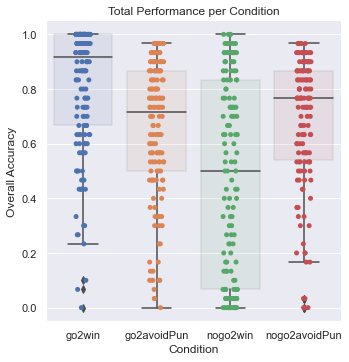

In [9]:
mapping = {'1': 'go2win', '2': 'nogo2win', '3': 'go2avoidPun', '4' : 'nogo2avoidPun'} 

circle_task_logs = first_session_clean_data[first_session_clean_data.exp_stage == 'main_target_detection']

circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)
performance_per_condition = circle_task_logs.groupby(['mturkID','cond']).mean().reset_index()
performance_per_condition.cond = performance_per_condition.cond.map(mapping)

ax = sns.catplot(x="cond", y="correct", data=performance_per_condition, order= ['go2win','go2avoidPun' ,'nogo2win', 'nogo2avoidPun']);
ax = sns.boxplot(x="cond", y="correct", data= performance_per_condition, boxprops=dict(alpha=.1), order= ['go2win','go2avoidPun' ,'nogo2win', 'nogo2avoidPun']);

ax.set(xlabel="Condition", ylabel = "Overall Accuracy", title = 'Total Performance per Condition')
plt.show()


# NoGO 2 Win Performance Dist.

<AxesSubplot:ylabel='Frequency'>

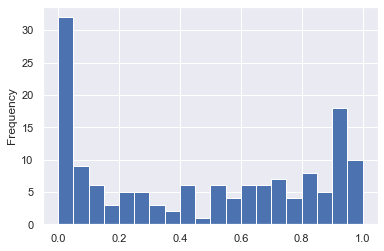

In [10]:
performance_per_condition[performance_per_condition.cond == 'nogo2win'].correct.plot(kind='hist', bins = 20)

# Extract demographic data

In [11]:
raw_demographic_data = first_session_clean_data[first_session_clean_data.trial_type == 'survey-html-form'][['mturkID', 'response']]
raw_demographic_data['gender'] = raw_demographic_data.response.apply(lambda x: x.split('"')[3])
raw_demographic_data['age'] = raw_demographic_data.response.apply(lambda x: x.split('"')[7])
raw_demographic_data['education_level'] = raw_demographic_data.response.apply(lambda x: x.split('"')[11])
raw_demographic_data['comments'] = raw_demographic_data.response.apply(lambda x: x.split('"')[15])
raw_demographic_data = raw_demographic_data.drop(['response'], axis=1)
raw_demographic_data.head()

,mturkID,gender,age,education_level,comments
1770,A353XKDTUX10NC,male,27,High,}
2577,A2NAKIXS3DVGAA,male,27,Bachelor,}
4200,A320QA9HJFUOZO,male,34,Bachelor,"Everything worked fine, thanks."
5007,AI4AO0O0WIJF7,female,46,High,}
6624,AKNYT1NTK2UFK,other,37,Bachelor,}


# Create final data to analyze

In [12]:
final_performace_data = performance_per_condition.pivot(index='mturkID', columns='cond', values='correct').reset_index()

final_performace_data = pd.merge(final_performace_data, accuracy_data, on='mturkID', how='left')
final_performace_data = pd.merge(final_performace_data, raw_demographic_data, on='mturkID')
final_performace_data.columns = ['mturkID', 'go2avoidPun_first_session', 'go2win_first_session', 'nogo2avoidPun_first_session', 'nogo2win_first_session', 'circle_side_performance_first_session',\
       'is_below_55_first_session', 'gender_first_session', 'age_first_session', 'education_level_first_session', 'comments_first_session']
overall_performance =  final_performace_data['nogo2win_first_session'] + \
                        final_performace_data['go2win_first_session'] + \
                        final_performace_data['nogo2avoidPun_first_session'] + \
                        final_performace_data['go2avoidPun_first_session']
final_performace_data['overall_performance'] = overall_performance/4

final_performace_data.head()

,mturkID,go2avoidPun_first_session,go2win_first_session,nogo2avoidPun_first_session,nogo2win_first_session,circle_side_performance_first_session,is_below_55_first_session,gender_first_session,age_first_session,education_level_first_session,comments_first_session,overall_performance
0,A10BH9PYCYUKDJ,0.100000,1.000000,0.833333,0.300000,0.983871,False,female,41,Associate,None,0.558333
1,A10JXOU89D5RXR,0.800000,1.000000,0.833333,0.000000,1.000000,False,female,60,Bachelor,none,0.658333
2,A10M63DSIGIEDI,0.466667,0.633333,0.000000,0.033333,0.610687,False,male,25,Bachelor,None,0.283333
3,A11S8IAAVDXCUS,0.733333,1.000000,0.966667,0.033333,1.000000,False,female,31,Associate,},0.683333
4,A12FTSX85NQ8N9,0.566667,0.500000,0.866667,0.866667,0.895833,False,male,29,Bachelor,},0.700000


In [13]:
final_performace_data.to_csv('Data/first_round_final_performance.csv')

# Pavlovian Axis 
### learned individualas are those who their OVERALL PERFORMANCE > 0.65

(0.0, 1.0)

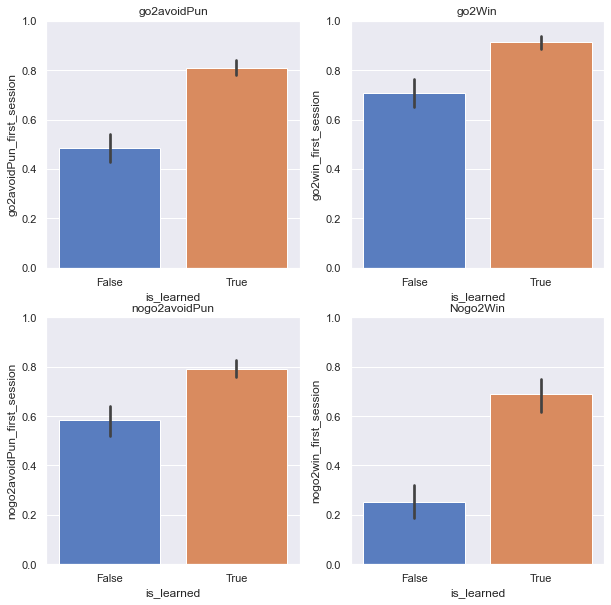

In [14]:
fig, axs = plt.subplots(ncols=2, nrows = 2, figsize=(10,10))
plt.ylim(0, 1)

final_performace_data['is_learned'] = final_performace_data.overall_performance > 0.65

sns.barplot(x="is_learned", y="nogo2win_first_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(1,1)]).set_title('Nogo2Win')

axs[1,1].set_ylim(0,1)

sns.barplot(x="is_learned", y="go2win_first_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(0,1)]).set_title('go2Win')
axs[0,1].set_ylim(0,1)



sns.barplot(x="is_learned", y="go2avoidPun_first_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(0,0)]).set_title('go2avoidPun')
axs[0,0].set_ylim(0,1)



sns.barplot(x="is_learned", y="nogo2avoidPun_first_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(1,0)]).set_title('nogo2avoidPun')
axs[1,0].set_ylim(0,1)




# Modelling

In [15]:
result_of_trials = circle_task_logs[['mturkID', 'internal_node_id', 'response', 'side', 'choice', 'cond_action', 'cond_outcome','correct_action', 'outcome', 'feedback_points', 'block']].copy()

result_of_trials['stimulus'] = result_of_trials['cond_action'] + '2' + result_of_trials['cond_outcome']
result_of_trials['is_go'] = result_of_trials.choice == 'go'
result_of_trials['is_go'].replace({True: 1, False: 0}, inplace=True)


In [16]:
go2win_go_prob = pd.Series(np.zeros(30))
go2win_prob_df = pd.DataFrame()

nogo2win_go_prob = pd.Series(np.zeros(30))
nogo2win_prob_df = pd.DataFrame()

go2avoidPun_go_prob = pd.Series(np.zeros(30))
go2avoidPun_prob_df = pd.DataFrame()

nogo2avoidPun_go_prob = pd.Series(np.zeros(30))
nogo2avoidPun_prob_df = pd.DataFrame()




for mID in result_of_trials.mturkID.dropna().unique():
    go_of_every_subject = result_of_trials[result_of_trials['mturkID']== mID][['is_go','stimulus']].reset_index(drop=True)
    for s in ['go2win','nogo2win','go2avoidPun', 'nogo2avoidPun']:
        go_of_every_subject_in_s = go_of_every_subject[go_of_every_subject.stimulus == s].reset_index(drop=True)
        if( s == 'go2win'):
            go2win_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            go2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'nogo2win'):
            nogo2win_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            nogo2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'go2avoidPun'):
            go2avoidPun_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            go2avoidPun_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'nogo2avoidPun'):
            nogo2avoidPun_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            nogo2avoidPun_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()


/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_20472/3190507868.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  go2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_20472/3190507868.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  nogo2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_20472/3190507868.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

In [17]:
go_prob_df = pd.DataFrame({'go2win': go2win_go_prob, 
                            'nogo2win': nogo2win_go_prob,
                            'go2avoidPun': go2avoidPun_go_prob,\
                            'nogo2avoidPun': nogo2avoidPun_go_prob})

# go_prob_df['idx'] = go_prob_df.index

go_prob_df = go_prob_df.melt().rename(columns={'variable': 'stimulus', 'value': 'go_prob'})


In [18]:
go_prob_df.loc[go_prob_df.stimulus == 'go2win', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'nogo2win', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'go2avoidPun', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'nogo2avoidPun', 'idx'] = range(0,30)
 

(0.0, 1.0)

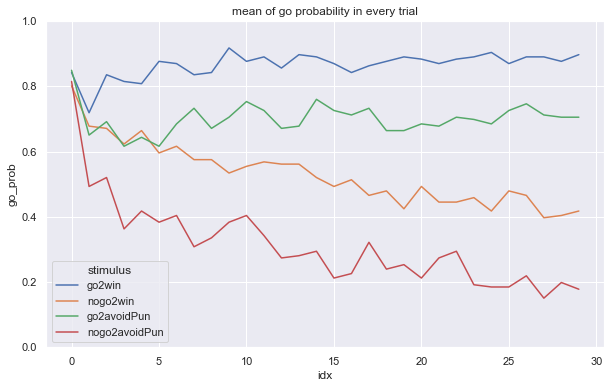

In [19]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="idx", y="go_prob",
             hue="stimulus", 
             data=go_prob_df)
plt.title("mean of go probability in every trial")
plt.ylim(0,1)


In [ ]:
from sys import path
